In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.insert(1, '/Users/milesturpin/Dev/latent_variable_nn')
sys.path.insert(1, '/Users/milesturpin/Dev/latent_variable_nn/models')

#from models.multilevel_layers import MultilevelDense

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential

from functools import reduce
import ipdb


tfd = tfp.distributions

In [3]:
%load_ext tensorboard

In [4]:
def data_generator(gid):
    #x_tf = tf.cast(tf.convert_to_tensor(gid), tf.int32)
    gid_tf = tf.cast(tf.convert_to_tensor(gid), tf.int32)
    num_groups = tf.cast(tf.convert_to_tensor(max(gid) + 1), tf.int32)
    """Creates a joint distribution for the varying slope model."""
    return tfd.JointDistributionSequential([
        tfd.Normal(loc=1., scale=0.1, name='w_z_0'),
#         tfd.Independent(
#             tfd.HalfCauchy(loc=tf.ones([num_groups])*0.1, scale=0.01, name='w_lambda_k'),
#             reinterpreted_batch_ndims=1),
        tfd.HalfCauchy(loc=1, scale=0.01, name='w_lambda_k'),

        lambda w_lambda_k, w_z_0: tfd.Independent(tfd.Normal( 
            loc=tf.ones([num_groups])*w_z_0,
            scale=w_lambda_k,
            name='w_z_k'), reinterpreted_batch_ndims=1),

        lambda w_z_k: tfd.MultivariateNormalDiag(  # y
            loc=tf.gather(w_z_k, gid_tf, axis=-1) ,
            scale_identity_multiplier=0.5,
            name='x')
   ])

In [405]:
ng=10
avg_samp = 50
np.random.seed(35)
gi = np.random.choice(ng, size=[ng*avg_samp])

In [406]:
import collections
collections.Counter(gi)

Counter({9: 48, 7: 51, 1: 37, 0: 50, 8: 59, 2: 62, 5: 38, 3: 55, 6: 49, 4: 51})

In [407]:
gen_process = data_generator(gi)

In [408]:
tf.random.set_seed(5)
gen = gen_process.sample(seed=7)

In [409]:
xi=gen[-1].numpy()
gen[:-1]

[<tf.Tensor: shape=(), dtype=float32, numpy=0.9272164>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.276844>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ 4.289809  ,  0.56151044, -2.057742  , -1.2611173 ,  0.62570345,
         0.6008022 , -2.8858562 ,  0.7954581 ,  0.58332413,  0.34865123],
       dtype=float32)>]

In [410]:
yi = 2.*xi + 1. + np.random.randn(len(xi))/5

In [411]:
x_train, x_test, y_train, y_test,  gid_train, gid_test = train_test_split(
    xi, yi, gi, stratify=gi, random_state=9, test_size=0.9)
tts = [x_train, x_test, y_train, y_test, gid_train, gid_test]

x_train = tf.convert_to_tensor(x_train)[...,tf.newaxis]
x_test = tf.convert_to_tensor(x_test)[...,tf.newaxis]
y_train = tf.convert_to_tensor(y_train)[...,tf.newaxis]
y_test = tf.convert_to_tensor(y_test)[...,tf.newaxis]
gid_train = tf.cast(tf.convert_to_tensor(gid_train), tf.int32)
gid_test = tf.cast(tf.convert_to_tensor(gid_test), tf.int32)

## Baseline model

In [412]:
def mean_estimator_error(train, test):
    return np.abs(np.mean(train) - np.mean(test))
    

In [413]:
check_tensor = lambda x: isinstance(x, tf.python.framework.ops.EagerTensor)

In [414]:
def get_segments(data, gid, idx): 
    if check_tensor(data):
        data = data.numpy()
    if check_tensor(gid):
        gid = gid.numpy()
    return data[np.where(gid == idx)[0]]

In [415]:
print('Baseline estimator:', mean_estimator_error(x_train, x_test))

Baseline estimator: 0.033158585


In [416]:
for i in range(ng):
    train = get_segments(x_train, gid_train, i)
    test = get_segments(x_test, gid_test, i)
    print('Baseline estimator per group:', mean_estimator_error(train, test))

Baseline estimator per group: 0.24614668
Baseline estimator per group: 0.023810059
Baseline estimator per group: 0.065476894
Baseline estimator per group: 0.40621316
Baseline estimator per group: 0.31369454
Baseline estimator per group: 0.16790938
Baseline estimator per group: 0.028253317
Baseline estimator per group: 0.367454
Baseline estimator per group: 0.0071002245
Baseline estimator per group: 0.06261778


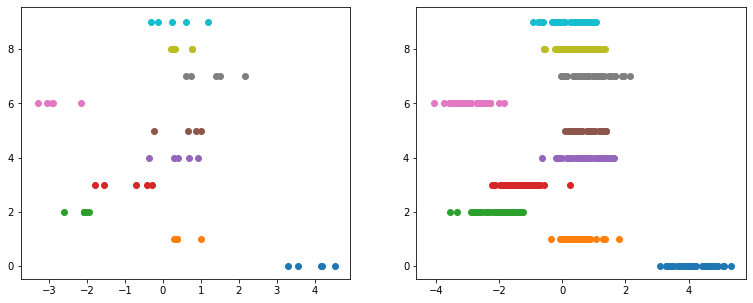

In [417]:
fig, axes =plt.subplots(1,2, figsize=(13,5))
for i in range(ng):
    
    axes[0].scatter(get_segments(x_train, gid_train, i), [i]*len(get_segments(x_train, gid_train, i)))

    axes[1].scatter(get_segments(x_test, gid_test, i), [i]*len(get_segments(x_test, gid_test, i)))

In [418]:
gen[2]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 4.289809  ,  0.56151044, -2.057742  , -1.2611173 ,  0.62570345,
        0.6008022 , -2.8858562 ,  0.7954581 ,  0.58332413,  0.34865123],
      dtype=float32)>

## Model classes

In [1045]:
class HierarchicalVariableLayer(tf.keras.layers.Layer):
    
    def __init__(self, variable_shape, num_groups, kl_weight,
                 #prior_kl_weight, group_kl_weights, 
                 **kwargs):
        super(HierarchicalVariableLayer, self).__init__(**kwargs)
        self.variable_shape = variable_shape
        # flatten out input into a vector
        if isinstance(variable_shape, list) or isinstance(variable_shape, tuple):
            self.units = reduce(lambda x, y: x*y, variable_shape)
        else:
            self.units = variable_shape
        #    self.units = int(variable_shape)
        
        self.num_groups = num_groups

#         self.prior_kl_weight = prior_kl_weight
#         self.group_kl_weights = group_kl_weights
        self.kl_weight = kl_weight

        
#         self.input_spec = [
#             tf.keras.layers.InputSpec(min_ndim=2),
#             tf.keras.layers.InputSpec(ndim=1)]
        
    def build(self, input_shape):
        
        # TODO: do something diff for only 1?
#         x_input_shape, gid_input_shape = input_shape
#         last_dim = x_input_shape[-1]
#         self.input_spec = [
#             tf.keras.layers.InputSpec(min_ndim=2, axes={-1: last_dim}),
#             tf.keras.layers.InputSpec(ndim=1)]
        
        
        # Mean of the variational posterior for group latents
        self.mu_k = self.add_weight(
            shape=(self.num_groups, self.units),
            initializer='random_normal', name='mu_k')
        # Variance of the variational posterior for group latents
        self.sigma_k = self.add_weight(
            shape=(self.num_groups, self.units),
            initializer=tf.constant_initializer(-4.), name='sigma_k')

        # Mean of the variational posterior for group prior z_0 
        self.mu0 = self.add_weight(
            shape=(self.units,),
            initializer='zeros', name='mu0')
        # Variance of the variational posterior for the group mean z_0
        self.sigma0 = self.add_weight(
            shape=(self.units,),
            initializer=tf.constant_initializer(-4.), name='sigma0')
        
        # Fixed parameters for hyperprior over z_0 ~ N(0, v^-1)
        self.z0_prior_mean = tf.Variable(0., trainable=False, name='z0_prior_mean')
        self.z0_prior_variance = tf.Variable(100., trainable=False, name='z0_prior_variance')

#         # Mean of the variational posterior for group prior variance tau_k 
        self.tau_k_mu = self.add_weight(
            shape=[self.units],
            #shape=(self.num_groups, self.units),
            initializer=tf.constant_initializer(1.), name='tau_k_mu')
        # Variance of the variational posterior for the group prior variance tau_k
        self.tau_k_sigma = self.add_weight(
            shape=[self.units],
            #shape=(self.num_groups, self.units),
            initializer=tf.constant_initializer(-1.), name='tau_k_sigma')        
        
#         # Fixed parameters for hyperprior over tau_k ~ N(0, tau_0)
        self.tau_k_prior_mean = tf.Variable(1., trainable=False, name='tau_k_prior_mean')
#         # Fixed hyperprior over tau_k, aka tau_0
        self.tau_k_prior_variance = tf.Variable(1., trainable=False, name='tau_k_prior_variance')
        
        # Fixed parameters for hyperprior over tau_k ~ N(0, tau_0)
        #self.tau_k_mu = tf.Variable(1., trainable=False, name='tau_k_mu')
        # Fixed hyperprior over tau_k, aka tau_0
        #self.tau_k_sigma = tf.Variable(0.1, trainable=False, name='tau_k_sigma')

        super(HierarchicalVariableLayer, self).build(input_shape)
        
    
    @tf.function
    def sample_posterior(self, mu, sigma):
        # By sampling after gather, I use different noise for each sample
        eps = np.random.randn(*mu.shape)
        samp = mu + sigma*eps
        return samp

    @tf.function
    def compute_kl(self, mu1, sigma1, mu2, sigma2):
        kl = (
            tf.math.log(sigma2/sigma1)
            + (sigma1**2 + (mu1-mu2)**2)/(2*sigma2**2)
            - 0.5)
        return kl
    
         
    @tf.function
    def call(self, gid):

        #assert len(gid.shape) == 1, "gid should be flat vector!"
        
        var_activation = tf.math.softplus
        sigma_k_pos = var_activation(self.sigma_k)
        sigma0_pos = var_activation(self.sigma0)
        tau_k_sigma_pos = var_activation(self.tau_k_sigma)
        
        
        # KL between var post on z0 and fixed prior over z0        
        z0_kl_loss_fn = lambda: tf.multiply(
            self.kl_weight,
            tf.reduce_sum(self.compute_kl(
                self.mu0, 
                # Changed from sigma0_pos to this to make it work...
                var_activation(self.sigma0),
                self.z0_prior_mean, self.z0_prior_variance)))

        tau_k_kl_loss_fn = lambda: tf.reduce_sum(
            tf.multiply(
            self.kl_weight,
            self.compute_kl(
                self.tau_k_mu, var_activation(self.tau_k_sigma),
                self.tau_k_prior_mean, self.tau_k_prior_variance)))

        def z_k_kl_loss_fn(): 
            sigma_k_pos = var_activation(self.sigma_k)
            tau_k = self.sample_posterior(self.tau_k_mu, var_activation(self.tau_k_sigma))        
            tau_k_sq = tau_k ** 2 
            z0 = self.sample_posterior(self.mu0, var_activation(self.sigma0))
            kl = self.compute_kl(self.mu_k, sigma_k_pos, z0, tau_k_sq)
        
            return tf.multiply(self.kl_weight, tf.reduce_sum(kl))
        
        def z_k_kl_loss_fn():
            sigma_k_pos = var_activation(self.sigma_k)
            tau_k = self.sample_posterior(self.tau_k_mu, var_activation(self.tau_k_sigma))        
            tau_k_sq = tau_k ** 2 
            sigma0_pos = var_activation(self.sigma0)
            #z0 = self.sample_posterior(self.mu0, var_activation(self.sigma0))
            
#             tf.print(tf.reduce_sum(sigma_k_pos, axis=[-1]) 
#             , tf.reduce_sum(sigma0_pos, axis=[-1]) ,
#                 tf.einsum('kd, kd  -> k', self.mu_k, self.mu_k)
#             , tf.einsum('d,d -> ', self.mu0,self.mu0)
#             , -2 * tf.einsum('kd,d -> k', self.mu_k, self.mu0))
            
            d = self.units
            z_k_log_prob = (
                - 1/2 * d * np.log(2*np.pi) 
                - 1/2 * d * tf.math.log(tau_k_sq)
                - 1/2/tau_k_sq * (
                    # NOTE: trace(sigma_k) sums over units
                    tf.reduce_sum(sigma_k_pos, axis=[-1]) 
                    + tf.reduce_sum(sigma0_pos, axis=[-1]) 
                    + tf.einsum('kd, kd -> k', self.mu_k, self.mu_k)
                    + tf.einsum('d, d -> ', self.mu0, self.mu0)
                    - 2 * tf.einsum('kd, d -> k', self.mu_k, self.mu0)))
            
            return -1 * tf.multiply(self.kl_weight, tf.reduce_sum(z_k_log_prob))
        
#         def z_k_kl_loss_fn():
#             z = self.sample_posterior(self.mu_k, var_activation(self.sigma_k))
#             tau_k = self.sample_posterior(self.tau_k_mu, var_activation(self.tau_k_sigma))        
#             tau_k_sq = tau_k ** 2 
#             z0 = self.sample_posterior(self.mu0, var_activation(self.sigma0))
#             return tf.reduce_sum(-1 * tfd.Normal(z0, tau_k_sq).log_prob(z))

        
        # Can access using model.metrics later once I do custom training
        self.add_metric(z0_kl_loss_fn(), name='z0_kl_loss', aggregation='mean')
        self.add_metric(tau_k_kl_loss_fn(), name='tau_k_kl_loss', aggregation='mean')
        self.add_metric(z_k_kl_loss_fn(), name='z_k_kl_loss', aggregation='mean')
        
        self.add_loss(z0_kl_loss_fn)
        self.add_loss(tau_k_kl_loss_fn)
        self.add_loss(z_k_kl_loss_fn)
        
        gather = lambda x: tf.gather(x, gid)
        z = self.sample_posterior(gather(self.mu_k), gather(sigma_k_pos))
        var = tf.reshape(z, [-1, *self.variable_shape])
        
        return var
    

In [1046]:
@tf.function
def tf_gather(x, ind):
    return tf.gather(x + 0, ind)

In [1007]:
# group_kl_weights should be [k1, k2, k3] / train_size

## Single parameter

In [1008]:
var = HierarchicalVariableLayer((50,200), 30, 1.)

In [1009]:
from collections import Counter

In [1010]:
len(x_train)

50

In [1011]:
print(num_batches)
print(1/num_batches)
#print(group_kl_weights)

2.0
0.5


In [1012]:
# KL terms
tfd.kl_divergence(tfd.Normal(0., tf.math.exp(-4.)), tfd.Normal(0. , 100.))

<tf.Tensor: shape=(), dtype=float32, numpy=8.10517>

In [1013]:
# KL terms
tfd.kl_divergence(tfd.Normal([-1.,  -1., -1.], tf.math.exp(-2.)), tfd.Normal(0. , 1.))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.009158, 2.009158, 2.009158], dtype=float32)>

In [1014]:
# KL terms
tfd.kl_divergence(tfd.Normal([-1.,  2., 2.], tf.nn.softplus(1.)), tfd.Normal(0. , 1.))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.5898142, 2.0898142, 2.0898142], dtype=float32)>

In [1015]:
def z_k_kl_loss_fn():
#     z = tf.reduce_mean(
#         tfd.Normal(tf.convert_to_tensor([1., -1., 1.]), 
#                    tf.convert_to_tensor([0.1, 0.1, 0.1]))
#         .sample(100), axis=0)
    mu0 = tf.reduce_mean(tfd.Normal(1., tf.nn.softplus(-2.)).sample(100), axis=0)
    z = tf.reduce_mean(
        tfd.Normal(
            tf.convert_to_tensor([1.]), 
            tf.convert_to_tensor([2.]))
        .sample(100), axis=0)
    print(mu0)
    print(z)
    return -1 * tfd.Normal(mu0, 1).log_prob(z)

In [1016]:
z_k_kl_loss_fn()

tf.Tensor(0.99928784, shape=(), dtype=float32)
tf.Tensor([1.1110892], shape=(1,), dtype=float32)


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9251883], dtype=float32)>

In [1017]:
tfd.Normal(1, 0.0001).log_prob([1])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([8.291402], dtype=float32)>

In [1018]:
muk = tf.convert_to_tensor(np.ones([3,4])*10.)
mu0 = tf.convert_to_tensor(np.ones([4])*12.)

(tf.einsum('kd, kd  -> k', muk, muk) 
 + tf.einsum('d,d -> ', mu0, mu0)
            - 2 * tf.einsum('kd,d -> k', muk, mu0))

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([16., 16., 16.])>

In [1019]:
muk

<tf.Tensor: shape=(3, 4), dtype=float64, numpy=
array([[10., 10., 10., 10.],
       [10., 10., 10., 10.],
       [10., 10., 10., 10.]])>

In [1020]:
mu0

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([12., 12., 12., 12.])>

In [1021]:
def z_k_kl_loss_fn():
    #sigma_k_pos = var_activation(self.sigma_k)
    #tau_k = self.sample_posterior(self.tau_k_mu, var_activation(self.tau_k_sigma))        
#     sigma_k_pos = tf.convert_to_tensor([0.1, 0.1, 0.1])
    sigma_k_pos = tf.convert_to_tensor([2.])
    tau_k_sq = tf.convert_to_tensor([1.])
    sigma0_pos = tf.convert_to_tensor([tf.nn.softplus(-2.)])
    #mu_k = tf.convert_to_tensor([1., -1., 1.])
    mu_k = tf.convert_to_tensor([1.])
    mu0 = tf.convert_to_tensor(1.)
    #z0 = self.sample_posterior(self.mu0, var_activation(self.sigma0))

#     print(tf.reduce_sum(sigma_k_pos, axis=[-1]) 
#             , tf.reduce_sum(sigma0_pos, axis=[-1]) ,
#         tf.einsum('i, i  -> i', mu_k, mu_k)
#             , tf.einsum(', -> ', mu0, mu0)
#             ,- 2 * tf.einsum('i, -> i', mu_k, mu0))
    d = 1
    z_k_log_prob = (
        - 1/2 * d * np.log(2*np.pi) 
        - 1/2 * d * tf.math.log(tau_k_sq)
        - 1/2/tau_k_sq * (
            tf.reduce_sum(sigma_k_pos, axis=[-1]) 
            + tf.reduce_sum(sigma0_pos, axis=[-1]) 
            + tf.einsum('i, i  -> i', mu_k, mu_k)
            + tf.einsum(', -> ', mu0, mu0)
            - 2 * tf.einsum('i, -> i', mu_k, mu0)))

    return -1* z_k_log_prob
    #return -1 * tf.multiply(1, tf.reduce_sum(z_k_log_prob))

In [1022]:
z_k_kl_loss_fn()

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.9824027], dtype=float32)>

In [1023]:
def z_k_kl_loss_fn(): 
    #tau_k = self.sample_posterior(self.tau_k_mu, var_activation(self.tau_k_sigma))  
    #tau_k = tfd.Normal([-1,2,2], 0.1).sample()
    #tau_k_sq = tau_k ** 2 
    tau_k_sq = 1
    z0 = tfd.Normal(1., tf.nn.softplus(0.1)).sample()
    z0 = 0.
    print(z0, tau_k_sq)
    return tfd.kl_divergence(tfd.Normal([-1.,1.,1.], tf.nn.softplus(-2.)), tfd.Normal(z0, tau_k_sq))
    


In [1024]:
z_k_kl_loss_fn()

0.0 1


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.0721903, 2.0721903, 2.0721903], dtype=float32)>

In [1047]:
batch_size=25
num_batches = np.ceil(len(x_train) / batch_size)
count_dict = Counter(gid_train.numpy())
group_train_sizes = np.array([count_dict[i] for i in range(ng)])
# I think this is actually not correct
#group_kl_weights = group_train_sizes / num_batches

In [1048]:
gid = Input(shape=[1], dtype=tf.int32, batch_size=batch_size)
x_hier = HierarchicalVariableLayer(
    variable_shape=(1,), 
    num_groups=tf.convert_to_tensor(ng),
    # Make sure this prior weight stays updated
#     prior_kl_weight=tf.convert_to_tensor(num_batches, dtype=tf.float32),
#     group_kl_weights=tf.convert_to_tensor(group_kl_weights, dtype=tf.float32))
    kl_weight=tf.convert_to_tensor(1/num_batches, dtype=tf.float32))
out = x_hier(gid)
model = Model(
    inputs=gid, 
    outputs=out)

In [1049]:
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.SUM)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
    loss=mse,
    metrics=['mse'])

In [1050]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model.fit(x=gid_train, 
          y=x_train, 
          batch_size=batch_size, 
          epochs=100, 
          #verbose=False,
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir='../experiments/parameter_est/' + current_time, 
                                                    profile_batch='5',
                                                    histogram_freq=10)])

Epoch 1/100
2/2 [==============================] - 0s 3ms/step - loss: 105.0995 - mse: 3.3316 - z0_kl_loss: 4.0324 - tau_k_kl_loss: 0.3758 - z_k_kl_loss: 6.4968
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 90.2470 - mse: 2.8154 - z0_kl_loss: 3.9335 - tau_k_kl_loss: 0.4716 - z_k_kl_loss: 5.5259
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 79.2320 - mse: 2.4474 - z0_kl_loss: 3.8351 - tau_k_kl_loss: 0.5914 - z_k_kl_loss: 4.5975
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 70.2974 - mse: 2.1162 - z0_kl_loss: 3.7383 - tau_k_kl_loss: 0.7327 - z_k_kl_loss: 4.2252
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 66.3367 - mse: 1.8280 - z0_kl_loss: 3.6475 - tau_k_kl_loss: 0.8445 - z_k_kl_loss: 5.8269
Epoch 6/100
2/2 [==============================] - 0s 2ms/step - loss: 62.4880 - mse: 1.6195 - z0_kl_loss: 3.5742 - tau_k_kl_loss: 0.8121 - z_k_kl_loss: 6.6133
Epoch 7/100
2/2 [======================

In [34]:
#--host localhost

In [974]:
%tensorboard --logdir=../experiments/parameter_est/ 

In [975]:
def hierarchical_estimator_error(pred, test):
    return np.abs(pred - np.mean(test))

In [1051]:
for i in range(ng):
    train = get_segments(x_train, gid_train, i)
    test = get_segments(x_test, gid_test, i)
    print('Baseline estimator per group:', mean_estimator_error(train, test))
    print('Hierarchical estimator per group:', hierarchical_estimator_error(
        model.get_weights()[0][i,0], test))

Baseline estimator per group: 0.24614668
Hierarchical estimator per group: 0.4300878
Baseline estimator per group: 0.023810059
Hierarchical estimator per group: 0.00587973
Baseline estimator per group: 0.065476894
Hierarchical estimator per group: 0.033417463
Baseline estimator per group: 0.40621316
Hierarchical estimator per group: 0.4464631
Baseline estimator per group: 0.31369454
Hierarchical estimator per group: 0.3300223
Baseline estimator per group: 0.16790938
Hierarchical estimator per group: 0.19196707
Baseline estimator per group: 0.028253317
Hierarchical estimator per group: 0.18059921
Baseline estimator per group: 0.367454
Hierarchical estimator per group: 0.2943706
Baseline estimator per group: 0.0071002245
Hierarchical estimator per group: 0.014726609
Baseline estimator per group: 0.06261778
Hierarchical estimator per group: 0.032185733


In [1052]:
model.get_weights()

[array([[ 3.770542  ],
        [ 0.49348873],
        [-2.0392046 ],
        [-0.9103699 ],
        [ 0.36734965],
        [ 0.5442452 ],
        [-2.7121506 ],
        [ 1.2008336 ],
        [ 0.4318366 ],
        [ 0.2832278 ]], dtype=float32), array([[-5.1138377],
        [-5.835897 ],
        [-5.6490517],
        [-6.784661 ],
        [-6.6830845],
        [-6.4983187],
        [-4.926761 ],
        [-5.0217986],
        [-6.1543636],
        [-4.746539 ]], dtype=float32), array([0.15041177], dtype=float32), array([0.17162338], dtype=float32), array([0.68814236], dtype=float32), array([0.15417106], dtype=float32), 0.0, 100.0, 1.0, 1.0]

In [1053]:
for i in range(ng):
    print(np.mean(get_segments(x_train, gid_train, i)))

3.954483
0.51141906
-2.138099
-0.9506198
0.38367742
0.56830287
-2.8644965
1.273917
0.439463
0.31365985


In [1054]:
np.mean([np.mean(get_segments(x_train, gid_train, i)) for i in range(ng)])

0.14917071

In [1055]:
gen[:-1]

[<tf.Tensor: shape=(), dtype=float32, numpy=0.9272164>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.276844>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ 4.289809  ,  0.56151044, -2.057742  , -1.2611173 ,  0.62570345,
         0.6008022 , -2.8858562 ,  0.7954581 ,  0.58332413,  0.34865123],
       dtype=float32)>]

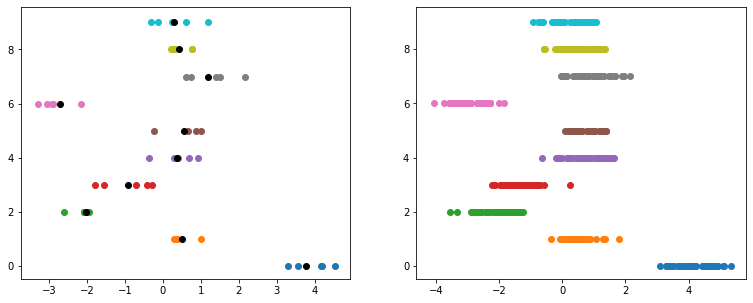

In [1059]:
fig, axes =plt.subplots(1,2, figsize=(13,5))
for i in range(ng):
    
    axes[0].scatter(get_segments(x_train, gid_train, i), [i]*len(get_segments(x_train, gid_train, i)))
    axes[0].scatter(model.get_weights()[0][i,0], i, c='black')
    axes[1].scatter(get_segments(x_test, gid_test, i), [i]*len(get_segments(x_test, gid_test, i)))
    

## Regression

In [1060]:
class MyMultilevelDense(tf.keras.layers.Layer):

    def __init__(self, units, num_groups,
                 multilevel_weights=True, 
                 multilevel_bias=True,
                 group_kl_weights=1.,
                 activation=None,
                 use_bias=True,
                 **kwargs):
        super(MyMultilevelDense, self).__init__(**kwargs)
        self.units = int(units)
        self.num_groups = num_groups
        self.multilevel_weights = multilevel_weights
        self.multilevel_bias = multilevel_bias
        self.group_kl_weights = group_kl_weights
        self.activation = tf.keras.activations.get(activation)
        self.use_bias = use_bias
#         self.input_spec = [
#             tf.keras.layers.InputSpec(min_ndim=2),
#             tf.keras.layers.InputSpec(ndim=1)]
        
    def build(self, input_shape):
        
        print(input_shape)
        x_input_shape, gid_input_shape = input_shape
        last_dim = x_input_shape[-1]
        print(self.units, last_dim)
#         self.input_spec = [
#             tf.keras.layers.InputSpec(min_ndim=2, axes={-1: last_dim}),
#             tf.keras.layers.InputSpec(ndim=1)]
        
        self.w = HierarchicalVariableLayer(
            variable_shape=[self.units, last_dim],
            num_groups=self.num_groups, 
            kl_weight=self.group_kl_weights,
            name='kernel')
        
        #if self.multilevel_bias:
        self.b = HierarchicalVariableLayer(
            variable_shape=[self.units],
            num_groups=self.num_groups, 
            kl_weight=self.group_kl_weights,
            name='bias')
        
        super(MyMultilevelDense, self).build(input_shape)
     
    @tf.function
    def call(self, inputs):
        
        #import ipdb; ipdb.set_trace()
        
        x, gid = inputs
        #print(x)
        batch_size, num_features = x.shape
        # Sanity checks
        #assert len(x.shape) >= 2, "Data is incorrect shape!"
        #assert len(gid.shape) == 1, "gid should be flat vector!"
        
        w = self.w(gid)
        b = self.b(gid)
            
        # B: batch size, p: num_features, u: num_units
        einsum_matrix_mult = '{},Bp->Bu'.format(
            'Bup' if self.multilevel_weights else 'up')
        outputs = tf.einsum(einsum_matrix_mult, w, x)

        # Sanity checks
        target_shape = (batch_size, self.units)
        msg = "output is shape {}, when should be shape {}".format(outputs.shape, target_shape)
        assert outputs.shape == target_shape, msg
        assert len(outputs.shape) == 2, "Output is wrong shape!"

        if self.use_bias:
            #outputs = tf.nn.bias_add(outputs, b)
            outputs = outputs + b

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

In [1061]:
ml_dense = MyMultilevelDense(2, 5)
ml_dense.build([[3,4], [3]])

[[3, 4], [3]]
2 4


In [439]:
%%time
#ml_dense([tf.zeros([3], dtype=np.float32), tf.convert_to_tensor([1,1,3])])
ml_dense([tf.zeros([3,4], dtype=np.float32), tf.convert_to_tensor([1,1,3])])

CPU times: user 516 ms, sys: 7.41 ms, total: 523 ms
Wall time: 522 ms


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.10893169, -0.05610539],
       [ 0.12497821, -0.04415904],
       [ 0.06597684,  0.02686396]], dtype=float32)>

In [440]:
for w in ml_dense.trainable_weights:
    print('{:50}{}'.format(w.name, w.shape))

kernel/mu_k:0                                     (5, 8)
kernel/sigma_k:0                                  (5, 8)
kernel/mu0:0                                      (8,)
kernel/sigma0:0                                   (8,)
kernel/tau_k_mu:0                                 (5, 8)
kernel/tau_k_sigma:0                              (5, 8)
bias/mu_k:0                                       (5, 2)
bias/sigma_k:0                                    (5, 2)
bias/mu0:0                                        (2,)
bias/sigma0:0                                     (2,)
bias/tau_k_mu:0                                   (5, 2)
bias/tau_k_sigma:0                                (5, 2)


In [441]:
ml_dense.w.mu_k

<tf.Variable 'kernel/mu_k:0' shape=(5, 8) dtype=float32, numpy=
array([[ 1.8501416e-03,  1.7296432e-02, -2.0775227e-02, -2.3526764e-02,
         2.7267812e-02, -3.7185002e-02, -6.7756720e-02, -1.0620358e-01],
       [-2.4482163e-02,  1.0088761e-04,  2.5464961e-02,  5.5881571e-02,
         1.1971504e-02, -6.2160981e-03,  4.8162326e-02, -5.9795447e-02],
       [ 1.0677747e-02,  5.4472174e-02, -4.6662588e-02, -4.6387635e-02,
        -1.3321842e-02,  5.7152171e-02, -1.0693427e-01,  3.9643988e-02],
       [-2.4431769e-03, -8.4535154e-03, -4.2101458e-02,  1.2946784e-03,
         1.0733221e-02, -2.4324371e-02,  1.2822822e-01,  5.3705242e-02],
       [-1.4718369e-03, -7.3936194e-02, -6.3229525e-03,  4.0745344e-03,
        -4.0680684e-02, -3.3157025e-02,  1.4526195e-02,  2.7020663e-02]],
      dtype=float32)>

In [442]:
gen[:-1]

[<tf.Tensor: shape=(), dtype=float32, numpy=0.9272164>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.276844>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ 4.289809  ,  0.56151044, -2.057742  , -1.2611173 ,  0.62570345,
         0.6008022 , -2.8858562 ,  0.7954581 ,  0.58332413,  0.34865123],
       dtype=float32)>]

In [443]:
ml_dense = MyMultilevelDense(1, 10)
ml_dense.build([[90,1], [90]])

[[90, 1], [90]]
1 1


In [447]:
%%time
#ml_dense([tf.zeros([3], dtype=np.float32), tf.convert_to_tensor([1,1,3])])
#ml_dense([x_train, gid_train])

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 9.06 µs


In [1062]:
model = tf.keras.Sequential([
    MyMultilevelDense(units=1, num_groups=5)])

In [1095]:
x = Input(shape=[1], dtype=tf.float32, batch_size=50)
gid = Input(shape=[1], dtype=tf.int32, batch_size=50)
mldense = MyMultilevelDense(units=1, num_groups=10)
out = mldense([x,gid])
model = Model(
    inputs=[
        #[...,tf.newaxis]
        x, gid], 
    outputs=out)

[TensorShape([50, 1]), TensorShape([50, 1])]
1 1


In [1096]:
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.SUM)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.03), 
    loss=mse,
    metrics=['mse'])
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [1097]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
np.random.seed(4)
model.fit(x=[x_train, gid_train], 
          y=(x_train*0.2+4.+ 0.2*np.random.randn(len(x_train))[...,tf.newaxis]), 
          batch_size=50, 
          epochs=100, 
         callbacks=[tf.keras.callbacks.TensorBoard(log_dir='../experiments/reg/' + current_time, 
                                                    profile_batch='5',
                                                    histogram_freq=10)])


Epoch 1/100


/Users/milesturpin/miniconda3/envs/latent2/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1/1 [==============================] - 0s 8ms/step - loss: 918.8531 - mse: 16.7631 - z0_kl_loss: 8.1143 - tau_k_kl_loss: 0.7098 - z_k_kl_loss: 11.1830
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 891.7833 - mse: 16.2448 - z0_kl_loss: 8.0845 - tau_k_kl_loss: 0.7336 - z_k_kl_loss: 10.8971
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 861.3592 - mse: 15.6596 - z0_kl_loss: 8.0548 - tau_k_kl_loss: 0.7585 - z_k_kl_loss: 10.6137
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 834.2944 - mse: 15.1418 - z0_kl_loss: 8.0251 - tau_k_kl_loss: 0.7845 - z_k_kl_loss: 10.3208
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 805.2383 - mse: 14.5845 - z0_kl_loss: 7.9955 - tau_k_kl_loss: 0.8116 - z_k_kl_loss: 10.0182
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 775.8379 - mse: 14.0206 - z0_kl_loss: 7.9658 - tau_k_kl_loss: 0.8398 - z_k_kl_loss: 9.7063
Epoch 7/100
1/1 [==================

In [1098]:
for w in model.weights:
    print(w.name) 
    print(w.numpy())
    print('\n')

kernel/mu_k:0
[[ 0.83441734]
 [ 2.089071  ]
 [-1.0097547 ]
 [-1.4385335 ]
 [ 1.9560344 ]
 [ 1.840174  ]
 [-0.5332895 ]
 [ 1.6452571 ]
 [ 2.0518682 ]
 [ 1.6336436 ]]


kernel/sigma_k:0
[[-4.2714143]
 [-4.354477 ]
 [-4.2537813]
 [-4.658683 ]
 [-4.2990494]
 [-4.482695 ]
 [-4.246948 ]
 [-3.850448 ]
 [-4.52718  ]
 [-4.375024 ]]


kernel/mu0:0
[0.905346]


kernel/sigma0:0
[-1.3389193]


kernel/tau_k_mu:0
[0.893217]


kernel/tau_k_sigma:0
[-0.04631918]


bias/mu_k:0
[[1.697501 ]
 [2.0516033]
 [1.692329 ]
 [1.9410629]
 [2.0961673]
 [2.0109098]
 [1.8323202]
 [1.8839426]
 [2.0744405]
 [2.1101747]]


bias/sigma_k:0
[[-5.561151 ]
 [-5.4070964]
 [-5.5803094]
 [-5.774615 ]
 [-5.1737623]
 [-5.1256876]
 [-5.8266478]
 [-5.3643117]
 [-5.3757563]
 [-5.3647223]]


bias/mu0:0
[1.9376873]


bias/sigma0:0
[-4.5012784]


bias/tau_k_mu:0
[-0.02452884]


bias/tau_k_sigma:0
[-0.886723]


kernel/z0_prior_mean:0
0.0


kernel/z0_prior_variance:0
100.0


kernel/tau_k_prior_mean:0
1.0


kernel/tau_k_prior_variance:0


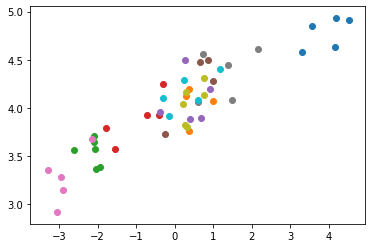

In [1094]:
np.random.seed(4)
for i in range(ng):
    tmp = get_segments(x_train, gid_train, i)
    plt.scatter(tmp,tmp*0.2+4.+0.2*np.random.randn(len(tmp))[...,tf.newaxis])

In [1092]:
%tensorboard --logdir=../experiments/reg/ 